# TIME based entries, exits

Recurring time bases entries and exits

Loaded env variables from file /Users/davidbrazda/Documents/Development/python/.env


Activating profile profile1

Realtime Websocket connection will use FEED: sip and credential of ACCOUNT1



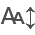

trades_df-BAC-2024-01-01T09_30_00-2024-05-14T16_00_00-CO4B7VPWUZF-100.parquet
trades_df-BAC-2024-01-11T09:30:00-2024-01-12T16:00:00.parquet
trades_df-SPY-2024-01-01T09:30:00-2024-05-14T16:00:00.parquet
trades_df-BAC-2023-01-01T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet
ohlcv_df-BAC-2024-01-11T09:30:00-2024-01-12T16:00:00.parquet
trades_df-BAC-2024-05-15T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet
ohlcv_df-BAC-2024-01-01T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet
ohlcv_df-SPY-2024-01-01T09:30:00-2024-05-14T16:00:00.parquet
ohlcv_df-BAC-2024-01-01T09_30_00-2024-05-14T16_00_00-CO4B7VPWUZF-100.parquet
ohlcv_df-BAC-2023-01-01T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet
ohlcv_df-BAC-2023-01-01T09_30_00-2024-05-25T15_30_00-47BCFOPUVWZ-100.parquet


In [1]:
from v2realbot.tools.loadbatch import load_batch
from v2realbot.utils.utils import zoneNY
import pandas as pd
import numpy as np
import vectorbtpro as vbt
from itables import init_notebook_mode, show
import datetime
from itertools import product
from v2realbot.config import ACCOUNT1_PAPER_API_KEY, ACCOUNT1_PAPER_SECRET_KEY, DATA_DIR

init_notebook_mode(all_interactive=True)

vbt.settings.set_theme("dark")
vbt.settings['plotting']['layout']['width'] = 1280
vbt.settings.plotting.auto_rangebreaks = True
# Set the option to display with pagination
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_rows', 10)  # Number of rows per page

# Define the market open and close times
market_open = datetime.time(9, 30)
market_close = datetime.time(16, 0)
entry_window_opens = 1
entry_window_closes = 370

forced_exit_start = 380
forced_exit_end = 390

#LOAD FROM PARQUET
#list all files is dir directory with parquet extension
dir = DATA_DIR + "/notebooks/"
import os
files = [f for f in os.listdir(dir) if f.endswith(".parquet")]
print('\n'.join(map(str, files)))
file_name = "ohlcv_df-BAC-2023-01-01T09_30_00-2024-05-25T15_30_00-47BCFOPUVWZ-100.parquet"
ohlcv_df = pd.read_parquet(dir+file_name,engine='pyarrow')
#filter ohlcv_df to certain date range (assuming datetime index)
ohlcv_df = ohlcv_df.loc["2024-02-12 9:30":"2024-02-14 16:00"]

#add vwap column to ohlcv_df
#ohlcv_df["hlcc4"] = (ohlcv_df["close"] + ohlcv_df["high"] + ohlcv_df["low"] + ohlcv_df["close"]) / 4

basic_data = vbt.Data.from_data(vbt.symbol_dict({"BAC": ohlcv_df}), tz_convert=zoneNY)
ohlcv_df= None

## Add resample function to custom columns

In [2]:
from vectorbtpro.utils.config import merge_dicts, Config, HybridConfig
from vectorbtpro import _typing as tp
from vectorbtpro.generic import nb as generic_nb

_feature_config: tp.ClassVar[Config] = HybridConfig(
    {
        "buyvolume": dict(
            resample_func=lambda self, obj, resampler: obj.vbt.resample_apply(
                resampler,
                generic_nb.sum_reduce_nb,
            )
        ),
        "sellvolume": dict(
            resample_func=lambda self, obj, resampler: obj.vbt.resample_apply(
                resampler,
                generic_nb.sum_reduce_nb,
            )
        )
    }
)

basic_data._feature_config = _feature_config

In [3]:
#asic_data.stats()
basic_data.wrapper.index.normalize().nunique()

3

In [5]:
basic_data.ohlcv.plot()

FigureWidget({
    'data': [{'close': array([33.   , 33.01 , 33.015, ..., 33.145, 33.145, 33.13 ]),
              'decreasing': {'fillcolor': '#ee534f', 'line': {'color': '#ee534f'}},
              'high': array([33.   , 33.05 , 33.02 , ..., 33.145, 33.145, 33.13 ]),
              'increasing': {'fillcolor': '#26a69a', 'line': {'color': '#26a69a'}},
              'low': array([33.  , 33.  , 33.  , ..., 33.14, 33.14, 33.13]),
              'name': 'OHLC',
              'opacity': 0.75,
              'open': array([33.  , 33.02, 33.  , ..., 33.14, 33.14, 33.13]),
              'type': 'candlestick',
              'uid': '8850593d-755a-4a3e-a805-75d2e0ce2713',
              'x': array([datetime.datetime(2024, 2, 12, 9, 30, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 9, 30, 1, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 9, 30, 2, tzinfo=<DstTzInfo 'U

In [6]:
t1data = basic_data[['open', 'high', 'low', 'close', 'volume','vwap','buyvolume','sellvolume']].resample("1T")

In [31]:
t1data = t1data.xloc["2024-02-12 9:30":"2024-02-12 10:20"]
#t1data = t1data.transform(lambda df: df.between_time('09:30', '10:00').dropna())


In [25]:
t1data = basic_data[['open', 'high', 'low', 'close', 'volume','vwap','buyvolume','sellvolume']]

time
2024-02-12 09:30:00-05:00    33.000
2024-02-12 09:30:01-05:00    33.010
2024-02-12 09:30:02-05:00    33.015
2024-02-12 09:30:03-05:00    33.080
2024-02-12 09:30:05-05:00    33.060
                              ...  
2024-02-14 15:59:55-05:00    33.145
2024-02-14 15:59:56-05:00    33.145
2024-02-14 15:59:57-05:00    33.145
2024-02-14 15:59:58-05:00    33.145
2024-02-14 15:59:59-05:00    33.130
Name: close, Length: 34058, dtype: float64

In [42]:
buyvolume = t1data.data["BAC"].buyvolume
sellvolume = t1data.data["BAC"].sellvolume
totalvolume = buyvolume + sellvolume

#adjust to minimal value to avoid division by zero
sellvolume_adjusted = sellvolume.replace(0, 1e-10)
oibratio = buyvolume / sellvolume

#cumulative order flow (net difference)
cof = buyvolume - sellvolume

# Calculate the order imbalance (net differene) normalize the order imbalance by calculating the difference between buy and sell volumes and then scaling it by the total volume.
order_imbalance = cof / totalvolume
order_imbalance.fillna(0) #nan nahradime 0

order_imbalance_allvolume = cof / t1data.data["BAC"].volume

In [50]:
cof


time
2024-02-12 09:30:00-05:00         0.0
2024-02-12 09:30:01-05:00    264765.0
2024-02-12 09:30:02-05:00      -100.0
2024-02-12 09:30:03-05:00     -1668.0
2024-02-12 09:30:05-05:00      -100.0
                               ...   
2024-02-12 10:19:46-05:00         0.0
2024-02-12 10:19:48-05:00      -300.0
2024-02-12 10:19:49-05:00         0.0
2024-02-12 10:19:51-05:00     -5125.0
2024-02-12 10:19:52-05:00       100.0
Length: 1819, dtype: float64

In [33]:
order_imbalance.vbt.plot()


FigureWidget({
    'data': [{'showlegend': False,
              'type': 'scatter',
              'uid': '2242e1ee-ab70-413f-bd43-af59f5e8ba40',
              'x': array([datetime.datetime(2024, 2, 12, 9, 30, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 9, 30, 1, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 9, 30, 2, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2024, 2, 12, 10, 19, 49, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 10, 19, 51, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 10, 19, 52, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>)],
                         dtype=object),
              'y': array([     

In [22]:
order_imbalance

time
2024-02-12 09:30:00-05:00         NaN
2024-02-12 09:30:01-05:00    0.992503
2024-02-12 09:30:02-05:00   -0.090909
2024-02-12 09:30:03-05:00   -0.297432
2024-02-12 09:30:05-05:00   -1.000000
                               ...   
2024-02-14 15:59:55-05:00   -0.395314
2024-02-14 15:59:56-05:00   -0.833092
2024-02-14 15:59:57-05:00   -0.571268
2024-02-14 15:59:58-05:00   -0.727273
2024-02-14 15:59:59-05:00   -1.000000
Length: 34058, dtype: float64

In [34]:
#priminds list (same Y as price), secinds list (secondary Y napr. rsi), close, voluminds (volume based) list
def plot_2y_close(priminds, secinds, close, volumeinds):
    fig = vbt.make_subplots(rows=2, cols=1, shared_xaxes=True, 
                            specs=[[{"secondary_y": True}], [{"secondary_y": False}]], 
                            vertical_spacing=0.02, subplot_titles=("Price and Indicators", "Volume"))

    # Plotting the close price
    close.vbt.plot(fig=fig, add_trace_kwargs=dict(secondary_y=False,row=1, col=1), trace_kwargs=dict(line=dict(color="blue")))
    
    # Plotting primary indicators on the first row
    for ind in priminds:
        if isinstance(ind, pd.Series):
            #if series has no name, make the name same as the variable name
            
            ind = ind.vbt
        ind.plot(fig=fig, add_trace_kwargs=dict(secondary_y=False, row=1, col=1))
    
    # Plotting secondary indicators on the first row
    for ind in secinds:
        #ind = ind.rename(str(ind.name))
        if isinstance(ind, pd.Series):
            ind = ind.vbt
        ind.plot(fig=fig, add_trace_kwargs=dict(secondary_y=True, row=1, col=1), trace_kwargs=dict(line=dict(color="rgba(255, 0, 0, 0.4)")))
    
    for indvolume in volumeinds:
        # Plotting the volume on the second row
        indvolume.rename(str(indvolume.name)).vbt.barplot(fig=fig, add_trace_kwargs=dict(secondary_y=False, row=2, col=1))
        #vbt.Bar(indvolume, fig=fig, add_trace_kwargs=dict(secondary_y=False, row=2, col=1))
    
    return fig

plot_2y_close([], [order_imbalance.rename("order_imbalance_norm")], t1data.close, [t1data.data["BAC"].buyvolume, t1data.data["BAC"].sellvolume, t1data.volume])


FigureWidget({
    'data': [{'line': {'color': 'blue'},
              'name': 'close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'c93f46da-c2c8-4fab-8e2a-64a071f207c0',
              'x': array([datetime.datetime(2024, 2, 12, 9, 30, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 9, 30, 1, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 9, 30, 2, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          ...,
                          datetime.datetime(2024, 2, 12, 10, 19, 49, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 10, 19, 51, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 10, 19, 52, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>)],


In [38]:
%matplotlib inline
t0data = basic_data
t1data = basic_data[['open', 'high', 'low', 'close', 'volume','vwap']].resample("1T")
t2data = basic_data[['open', 'high', 'low', 'close', 'volume','vwap']].resample("15T")
t3data = basic_data[['open', 'high', 'low', 'close', 'volume','vwap']].resample("30T")
t4data = basic_data[['open', 'high', 'low', 'close', 'volume', 'vwap']].resample("D").dropna()

t1data = t1data.transform(lambda df: df.between_time('09:30', '16:00').dropna())
t2data = t2data.transform(lambda df: df.between_time('09:30', '16:00').dropna())
t3data = t3data.transform(lambda df: df.between_time('09:30', '16:00').dropna())

#30min data to daily
# t4data = t3data.resample("D").dropna()

#t4data = t4data.transform(lambda df: df.between_time('09:30', '16:00').dropna())
#m1data.data["SPY"].info()

#m1data.data["SPY"].vbt.ohlcv.plot()
#h2data.data["SPY"].vbt.ohlcv.plot()
#ddata.data["SPY"]
t2data.data["BAC"].vbt.ohlcv.plot().show()


#t4data.data["BAC"]

In [21]:
t2data.close

#in df remove rows with nan


time
2024-02-12 10:30:00-05:00    33.425
2024-02-12 10:45:00-05:00    33.485
2024-02-12 11:00:00-05:00    33.580
2024-02-12 11:15:00-05:00    33.655
2024-02-12 11:30:00-05:00    33.695
                              ...  
2024-02-13 11:00:00-05:00    32.850
2024-02-13 11:15:00-05:00    32.880
2024-02-13 11:30:00-05:00    32.875
2024-02-13 11:45:00-05:00    32.860
2024-02-13 12:00:00-05:00    32.855
Name: close, Length: 33, dtype: float64

In [25]:
#realign na 1T = t1data + oriznout main session
t2data_vwap = t2data.vwap.vbt.realign_closing("1T").between_time('09:30', '16:00').dropna()
t3data_vwap = t3data.vwap.vbt.realign_closing("1T").between_time('09:30', '16:00').dropna()
t4data_vwap = t4data.vwap.vbt.realign_closing("1T").dropna()

In [29]:
t2data_vwap

time
2024-02-12 10:44:00-05:00    33.401845
2024-02-12 10:45:00-05:00    33.401845
2024-02-12 10:46:00-05:00    33.401845
2024-02-12 10:47:00-05:00    33.401845
2024-02-12 10:48:00-05:00    33.401845
                               ...    
2024-02-13 11:56:00-05:00    32.888874
2024-02-13 11:57:00-05:00    32.888874
2024-02-13 11:58:00-05:00    32.888874
2024-02-13 11:59:00-05:00    32.859478
2024-02-13 12:00:00-05:00    32.859478
Name: vwap, Length: 468, dtype: float64

In [39]:
def plot_2y_close(priminds, secinds, close):
    fig = vbt.make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]], vertical_spacing=0.02, subplot_titles=("MOM", "Price" ))
    close.vbt.plot(fig=fig, add_trace_kwargs=dict(secondary_y=False), trace_kwargs=dict(line=dict(color="blue")))
    for ind in priminds:
        if isinstance(ind, pd.Series):
            ind = ind.vbt
        ind.plot(fig=fig, add_trace_kwargs=dict(secondary_y=False))
    for ind in secinds:
        if isinstance(ind, pd.Series):
            ind = ind.vbt
        ind.plot(fig=fig, add_trace_kwargs=dict(secondary_y=True))
    return fig

In [43]:
t4data.clos.vbt 



time
2024-02-12 00:00:00-05:00    33.620
2024-02-13 00:00:00-05:00    32.760
2024-02-14 00:00:00-05:00    33.130
2024-02-15 00:00:00-05:00    34.060
2024-02-16 00:00:00-05:00    34.090
                              ...  
2024-03-07 00:00:00-05:00    35.610
2024-03-08 00:00:00-05:00    35.600
2024-03-11 00:00:00-04:00    35.900
2024-03-12 00:00:00-04:00    35.950
2024-03-13 00:00:00-04:00    36.346
Name: close, Length: 22, dtype: float64

In [ ]:
obvind = vbt.indicator.obv.run(t1data.close, t1data.volume)

In [48]:
t1_lengtgh = 15
t2_length = 15
t3_length = 15
t4_length = 5
t1_th = 0.1
t2_th = 0.1
t3_th = 0.1
t4_th = 0.1



#minute
t1slope = vbt.indicator("talib:LINEARREG_SLOPE ").run(t1data.close, timeperiod=t1_lengtgh) # -0.09, 0.09
t2slope = vbt.indicator("talib:LINEARREG_SLOPE ").run(t2data.vwap, timeperiod=t2_length) #   -0.08 , 0.079
t3slope = vbt.indicator("talib:LINEARREG_SLOPE ").run(t3data.vwap, timeperiod=t3_length) #   -0.08, 0.08
#daily
t4slope = vbt.indicator("talib:LINEARREG_SLOPE ").run(t4data.vwap, timeperiod=t4_length) #   -0.1, 0.09

plot_2y_close(priminds=[], secinds=[t1slope, t2slope, t3slope, t4slope], close=t1data.close).show()


In [49]:
#thirtymin_slope = thirtymin_slope.real.rename("30min") #timto se prejmenuje real na 30min
t3slope = t3slope.real.vbt.realign_closing("1T").between_time('09:30', '16:00').dropna()
##filter daily_slope_to_compare to only monday to friday
t3slope = t3slope[t3slope.index.dayofweek < 5]

#t3slope.info()

t2slope = t2slope.real.vbt.realign_closing("1T").between_time('09:30', '16:00').dropna()
##filter daily_slope_to_compare to only monday to friday
t2slope = t2slope[t2slope.index.dayofweek < 5]

t2slope.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 8469 entries, 2024-02-12 14:14:00-05:00 to 2024-03-13 12:00:00-04:00
Series name: 15
Non-Null Count  Dtype  
--------------  -----  
8469 non-null   float64
dtypes: float64(1)
memory usage: 132.3 KB


In [15]:
oibratio

time
2024-02-12 10:30:00-05:00    0.659296
2024-02-12 10:30:10-05:00    6.290000
2024-02-12 10:30:20-05:00    1.095687
2024-02-12 10:30:30-05:00    0.222612
2024-02-12 10:30:40-05:00    0.465000
                               ...   
2024-02-14 12:00:10-05:00    1.839216
2024-02-14 12:00:20-05:00    0.974684
2024-02-14 12:00:30-05:00         inf
2024-02-14 12:00:40-05:00    0.840336
2024-02-14 12:00:50-05:00    0.048008
Freq: 10s, Length: 17826, dtype: float64

In [32]:

#
short_entries = order_imbalance.vbt < 0.0002
#short_entries = oibratio.vbt < 0.01
short_entries.value_counts()

entries = order_imbalance.vbt > 0.7
#entries = oibratio.vbt > 10
entries.value_counts()

False    2956
True       15
Name: count, dtype: int64

In [33]:
fig = vbt.make_subplots(rows=3, cols=1, shared_xaxes=True, 
                        specs=[[{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": False}]], 
                        vertical_spacing=0.02, subplot_titles=("Price and Indicators", "Volume"))
t1data.data["BAC"].vbt.ohlcv.plot(fig=fig, add_trace_kwargs=dict(secondary_y=False, row=1, col=1))
#oibratio.vbt.plot(fig=fig, add_trace_kwargs=dict(secondary_y=True, row=1, col=1))
order_imbalance.vbt.plot(fig=fig, add_trace_kwargs=dict(secondary_y=True, row=1, col=1))
entries.vbt.signals.plot_as_entries(t1data.close, fig=fig, trace_kwargs=dict(name="LONGS",
                                                                                    line=dict(color="#ffe476"),
                                                                                    marker=dict(color="limegreen"),
                                                                                    fill=None,
                                                                                    connectgaps=True,
                                                                                    ), add_trace_kwargs=dict(secondary_y=False, row=1, col=1))

short_entries.vbt.signals.plot_as_entries(t1data.close, fig=fig, trace_kwargs=dict(name="SHORTS",
                                                                                    line=dict(color="#ffe476"),
                                                                                    marker=dict(color="red"),
                                                                                    fill=None,
                                                                                    connectgaps=True,
                                                                                    ), add_trace_kwargs=dict(secondary_y=False, row=1, col=1))


FigureWidget({
    'data': [{'close': array([33.385, 33.39 , 33.39 , ..., 33.025, 33.016, 32.98 ]),
              'decreasing': {'fillcolor': '#ee534f', 'line': {'color': '#ee534f'}},
              'high': array([33.3961, 33.4   , 33.4   , ..., 33.04  , 33.03  , 33.025 ]),
              'increasing': {'fillcolor': '#26a69a', 'line': {'color': '#26a69a'}},
              'low': array([33.36 , 33.38 , 33.385, ..., 33.015, 33.01 , 32.98 ]),
              'name': 'OHLC',
              'opacity': 0.75,
              'open': array([33.36 , 33.385, 33.39 , ..., 33.015, 33.02 , 33.015]),
              'type': 'candlestick',
              'uid': 'c74adf87-a9bf-4900-a1ab-21527974806d',
              'x': array([datetime.datetime(2024, 2, 12, 10, 30, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 10, 31, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 2, 12, 10, 32, tzinf

In [239]:
# thirtymin_slope_to_compare.vbt.xloc["04-16-2024"].get()
thirty_down_signal.vbt.xloc["04-16-2024"].get()


time
2024-04-16 09:30:00-04:00    False
2024-04-16 09:31:00-04:00    False
2024-04-16 09:32:00-04:00    False
2024-04-16 09:33:00-04:00    False
2024-04-16 09:34:00-04:00    False
                             ...  
2024-04-16 15:56:00-04:00    False
2024-04-16 15:57:00-04:00    False
2024-04-16 15:58:00-04:00    False
2024-04-16 15:59:00-04:00    False
2024-04-16 16:00:00-04:00    False
Name: 20, Length: 391, dtype: bool

In [53]:
#short_signal = t1slope.real_below(t1_th) & t2slope.real_below(t2_th) & t3slope.real_below(t3_th) & t4slope.real_below(t4_th)
#long_signal = t1slope.real_above(t1_th) & t2slope.real_above(t2_th) & t3slope.real_above(t3_th) & t4slope.real_above(t4_th)

#test na daily s reversem  crossed 0
short_signal = t2slope.vbt < -0.01 & t3slope.vbt < -0.01  #min value of threshold
long_signal = t2slope.vbt > 0.01 & t3slope.vbt > 0.01  #min

# thirty_up_signal = t3slope.vbt.crossed_above(0.01)
# thirty_down_signal = t3slope.vbt.crossed_below(-0.01)

fig = plot_2y_close(priminds=[], secinds=[t3slope], close=t1data.close)
#short_signal.vbt.signals.plot_as_entries(basic_data.close, fig=fig)

short_signal.vbt.signals.plot_as_entries(t1data.close, fig=fig, trace_kwargs=dict(name="SHORTS",
                                                                                    line=dict(color="#ffe476"),
                                                                                    marker=dict(color="red", symbol="triangle-down"),
                                                                                    fill=None,
                                                                                    connectgaps=True,
                                                                                    ))
long_signal.vbt.signals.plot_as_entries(t1data.close, fig=fig, trace_kwargs=dict(name="LONGS",
                                                                                    line=dict(color="#ffe476"),
                                                                                    marker=dict(color="limegreen"),
                                                                                    fill=None,
                                                                                    connectgaps=True,
                                                                                    ))

# thirty_down_signal.vbt.signals.plot_as_entries(t1data.close, fig=fig, trace_kwargs=dict(name="DOWN30",
#                                                                                     line=dict(color="#ffe476"),
#                                                                                     marker=dict(color="yellow", symbol="triangle-down"),
#                                                                                     fill=None,
#                                                                                     connectgaps=True,
#                                                                                     ))
# thirty_up_signal.vbt.signals.plot_as_entries(t1data.close, fig=fig, trace_kwargs=dict(name="UP30",
#                                                                                     line=dict(color="#ffe476"),
#                                                                                     marker=dict(color="grey"),
#                                                                                     fill=None,
#                                                                                     connectgaps=True,
#                                                                                     ))

# thirtymin_slope_to_compare.vbt.plot(fig=fig, add_trace_kwargs=dict(secondary_y=True), trace_kwargs=dict(name="30min slope",
#                                                                                         line=dict(color="yellow"),                                                                                     
#                                                                                         fill=None,
#                                                                                         connectgaps=True,
#                                                                                         ))

fig.show()
# print("short signal")
# print(short_signal.value_counts())

#forced_exit = pd.Series(False, index=close.index)
forced_exit = basic_data.symbol_wrapper.fill(False)
#entry_window_open = pd.Series(False, index=close.index)
entry_window_open=  basic_data.symbol_wrapper.fill(False)

# Calculate the time difference in minutes from market open for each timestamp
elapsed_min_from_open = (forced_exit.index.hour - market_open.hour) * 60 + (forced_exit.index.minute - market_open.minute)

entry_window_open[(elapsed_min_from_open >= entry_window_opens) & (elapsed_min_from_open < entry_window_closes)] = True

#print(entry_window_open.value_counts())

forced_exit[(elapsed_min_from_open >= forced_exit_start) & (elapsed_min_from_open < forced_exit_end)] = True
short_entries = (short_signal & entry_window_open)
short_exits = forced_exit

entries = (long_signal & entry_window_open)
exits = forced_exit
#long_entries.info()
#number of trues and falses in long_entries
# print(short_exits.value_counts())
# print(short_entries.value_counts())

#fig = plot_2y_close([],[momshort, rocp], close)
#short_signal.vbt.signals.plot_as_entries(close, fig=fig, add_trace_kwargs=dict(secondary_y=False))
#print(sl_stop)
#short_entries=short_entries, short_exits=short_exits,
# pf = vbt.Portfolio.from_signals(close=basic_data, entries=short_entries, exits=exits, tsl_stop=0.005, tp_stop = 0.05, fees=0.0167/100, freq="1s") #sl_stop=sl_stop, tp_stop = sl_stop,

# pf.stats()


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [29]:
# pf.plot()

FigureWidget({
    'data': [{'close': array([477.55  , 477.545 , 477.5088, ..., 476.6   , 476.66  , 476.665 ]),
              'decreasing': {'fillcolor': '#ee534f', 'line': {'color': '#ee534f'}},
              'high': array([477.59, 477.66, 477.62, ..., 476.73, 476.66, 476.68]),
              'increasing': {'fillcolor': '#26a69a', 'line': {'color': '#26a69a'}},
              'low': array([477.53, 477.54, 477.49, ..., 476.6 , 476.59, 476.63]),
              'name': 'OHLC',
              'opacity': 0.5,
              'open': array([477.58, 477.55, 477.61, ..., 476.71, 476.6 , 476.68]),
              'type': 'candlestick',
              'uid': '4806638f-1773-49e9-b51d-bd24ba7b62a8',
              'x': array([datetime.datetime(2024, 1, 11, 9, 30, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 1, 11, 9, 30, 1, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
                          datetime.datetime(2024, 1, 11, 9, 30, 

In [36]:
pf.get_drawdowns().records_readable

Drawdown Id            Column               Start Index  \
0             0  (0.0018, 0.0068) 2024-01-03 09:31:04-05:00   
1             1  (0.0018, 0.0068) 2024-01-03 09:31:07-05:00   
2             2  (0.0018, 0.0068) 2024-01-03 09:31:11-05:00   
3             3  (0.0018, 0.0068) 2024-01-03 09:31:18-05:00   
4             4  (0.0018, 0.0068) 2024-01-03 09:48:07-05:00   
..          ...               ...                       ...   
34           34  (0.0018, 0.0068) 2024-01-12 12:23:26-05:00   
35           35  (0.0018, 0.0068) 2024-01-12 12:23:31-05:00   
36           36  (0.0018, 0.0068) 2024-01-12 12:32:23-05:00   
37           37  (0.0018, 0.0068) 2024-01-12 12:32:27-05:00   
38           38  (0.0018, 0.0068) 2024-01-12 12:32:36-05:00   

                Valley Index                 End Index  Start Value  \
0  2024-01-03 09:31:05-05:00 2024-01-03 09:31:06-05:00   100.000000   
1  2024-01-03 09:31:10-05:00 2024-01-03 09:31:11-05:00   100.057784   
2  2024-01-03 09:31:13-05:00 2024-01-03 09:31:16-05:00   100.102472   
3  2024-01-03 09:32:39-05:00 2024-01-03 09:48:05-05:00   100.162057   
4  2024-01-03 09:48:08-05:00 2024-01-03 09:48:11-05:00   100.186396   
..                       ...                       ...          ...   
34 2024-01-12 12:23:28-05:00 2024-01-12 12:23:29-05:00   100.981534   
35 2024-01-12 12:26:27-05:00 2024-01-12 12:32:23-05:00   101.089545   
36 2024-01-12 12:32:24-05:00 2024-01-12 12:32:25-05:00   101.089545   
37 2024-01-12 12:32:28-05:00 2024-01-12 12:32:36-05:00   101.104975   
38 2024-02-21 09:35:15-05:00 2024-02-28 15:59:59-05:00   101.104975   

    Valley Value   End Value     Status  
0      99.983303  100.057784  Recovered  
1     100.042888  100.102472  Recovered  
2     100.057784  100.102472  Recovered  
3      99.650958  100.171522  Recovered  
4     100.171522  100.201269  Recovered  
..           ...         ...        ...  
34    100.968881  101.043254  Recovered  
35    100.858092  101.089545  Recovered  
36    101.074115  101.089545  Recovered  
37    101.089545  101.104975  Recovered  
38     99.788058   99.788058     Active  

[39 rows x 9 columns]

In [12]:
pf.orders.records_readable

Order Id  Column              Signal Index            Creation Index  \
0          0       0 2024-01-03 09:31:06-05:00 2024-01-03 09:31:06-05:00   
1          1       0 2024-01-03 09:31:06-05:00 2024-01-03 09:48:40-05:00   
2          2       0 2024-01-04 09:33:14-05:00 2024-01-04 09:33:14-05:00   
3          3       0 2024-01-04 09:33:14-05:00 2024-01-04 09:43:31-05:00   
4          4       0 2024-01-05 09:31:23-05:00 2024-01-05 09:31:23-05:00   
..       ...     ...                       ...                       ...   
51        51       0 2024-02-21 09:34:52-05:00 2024-02-21 09:45:00-05:00   
52        52       0 2024-02-22 09:31:22-05:00 2024-02-22 09:31:22-05:00   
53        53       0 2024-02-22 09:31:22-05:00 2024-02-22 09:38:13-05:00   
54        54       0 2024-02-23 09:31:25-05:00 2024-02-23 09:31:25-05:00   
55        55       0 2024-02-23 09:31:25-05:00 2024-02-23 09:35:02-05:00   

                  Fill Index      Size      Price      Fees  Side    Type  \
0  2024-01-03 09:31:06-05:00  2.981461  33.535000  0.016697  Sell  Market   
1  2024-01-03 09:48:40-05:00  2.981461  33.357264  0.016609   Buy  Market   
2  2024-01-04 09:33:14-05:00  2.976739  33.755000  0.016780  Sell  Market   
3  2024-01-04 09:43:31-05:00  2.976739  33.821568  0.016813   Buy  Market   
4  2024-01-05 09:31:23-05:00  2.972516  33.725000  0.016741  Sell  Market   
..                       ...       ...        ...       ...   ...     ...   
51 2024-02-21 09:45:00-05:00  3.023216  33.334240  0.016830   Buy  Market   
52 2024-02-22 09:31:22-05:00  3.001125  33.580000  0.016830  Sell  Market   
53 2024-02-22 09:38:13-05:00  3.001125  33.620000  0.016850   Buy  Market   
54 2024-02-23 09:31:25-05:00  2.990315  33.650000  0.016804  Sell  Market   
55 2024-02-23 09:35:02-05:00  2.990315  33.654100  0.016806   Buy  Market   

   Stop Type  
0       None  
1         TP  
2       None  
3        TSL  
4       None  
..       ...  
51       TSL  
52      None  
53       TSL  
54      None  
55       TSL  

[56 rows x 11 columns]